In [1]:
import torch
import os
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchsummary import summary
device = 'cpu'
path = os.path.abspath('../..')
path

'/home/upadesh/3_Codes/6_Au_Au_Laser'

In [2]:
# Plotting function for losses and accuracies
def plot_training_history(history_path='training_history.npy'):
    history = np.load(history_path, allow_pickle=True).item()
    
    for key in history:
        history[key] = history[key][1:]
    epochs = range(1, len(history['train_loss']) + 1)

    fig, ax1 = plt.subplots(1, 1, figsize=[7, 5], frameon=False) #figsize=[8, 10])
    ax2 = ax1.twinx()
    ax1.set_facecolor((0, 0, 0, 0))
    ax2.set_facecolor((0, 0, 0, 0))
    
    ax1.plot(epochs, history['train_loss'], color='red', marker='d', markersize=5,  linestyle='-', linewidth=1, label='Training Loss')
    ax1.plot(epochs, history['val_loss'], color='k', marker='o', markersize=5, linestyle='-', linewidth=1, label='Validation Loss')
    ax1.set_xlabel(r"Epochs $\mathbf{\longrightarrow}$", weight = 'bold', size=30, labelpad=5, color='k')
    ax1.set_ylabel(r"$\mathbf{\longleftarrow}$ Loss", weight = 'bold', size=30, labelpad=0, color='k')
    ax1.set_yticks([0, 0.01, 0.02,  0.03], labels=['0.00', 0.01, 0.02,  0.03], size=20, color='k', rotation=0,  weight='bold')
    ax1.set_xticks([0, 10, 20, 30, 40, 50], labels=[0, 10, 20, 30, 40, 50], size=20, color='k', weight='bold')
    ax1.legend(loc=(0.07, 0.35), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'12',},  handletextpad=0.5, handlelength=2, edgecolor="black", facecolor='None', frameon=True)
    
    
    ax2.plot(epochs, history['train_acc'], color='green', marker='d', markersize=5, linestyle='-', linewidth=2, label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], color='blue', marker='o', markersize=5, linestyle='-', linewidth=1, label='Validation Accuracy')
    ax2.set_ylabel(r"Accuracy $\mathbf{\longrightarrow}$", weight = 'bold', size=30, labelpad=0, color='k')
    ax2.set_yticks([0.988, 0.992, 0.996,  1.000], labels=[0.988, 0.992, 0.996,  '1.000'], size=20, color='green', rotation=0,  weight='bold')
    ax2.legend(loc=(0.52, 0.63), ncol=1,  columnspacing=1.0, prop={'weight':'bold', 'size':'12',},  handletextpad=0.5, handlelength=2, edgecolor="black", facecolor='None', frameon=True)
    
    ax1.set_ylim(-0.002, 0.032)
    ax1.set_xlim(right=52)
    ax2.set_ylim(0.987, 1.001)
    
    ax1.tick_params(axis='y', color='orangered', direction='inout', which='both', length=10, width=5)
    ax1.tick_params(axis='x', color='k', direction='inout', which='both', length=10, width=5)
    ax2.tick_params(axis='y', color='blue', direction='inout', which='both', length=10, width=5)
    
    ax1.spines[:].set_linewidth(4)
    ax1.spines['right'].set_color('blue')
    ax1.spines['left'].set_color('red')
    ax2.spines[:].set_linewidth(0)
    
    
    # plt.savefig('../../../6_Au_Au_Laser/6_Machine_Learning/figures/model_hisotry.png',bbox_inches='tight', dpi=800)
    # plt.savefig('../../../6_Au_Au_Laser/6_Machine_Learning/figures/jpg/model_hisotry.jpg',bbox_inches='tight')
    # plt.savefig('../../../0_GitHub_hostings/FreeEnergy_Benchmark_Model/6_Machine_Learning/figures/model_hisotry.png',bbox_inches='tight', dpi=800)
    # plt.savefig('../../../0_GitHub_hostings/FreeEnergy_Benchmark_Model/6_Machine_Learning/figures/jpg/model_hisotry.jpg',bbox_inches='tight')
    
    
    plt.show()

In [3]:
# UNet model definition
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, model_depth='low'):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        if model_depth == 'medium':
            # # Light Model
            self.encoder1 = conv_block(in_channels, 32)
            self.encoder2 = conv_block(32, 64)
            self.encoder3 = conv_block(64, 128)
            self.encoder4 = conv_block(128, 256)
            self.pool = nn.MaxPool2d(2)
            self.middle = conv_block(256, 512)
            self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
            self.decoder4 = conv_block(512, 256)
            self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
            self.decoder3 = conv_block(256, 128)
            self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
            self.decoder2 = conv_block(128, 64)
            self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
            self.decoder1 = conv_block(64, 32)
            self.final = nn.Conv2d(32, out_channels, kernel_size=1)
        
        elif model_depth == 'low':
            # # Ultra-light model
            self.encoder1 = conv_block(in_channels, 16)
            self.encoder2 = conv_block(16, 32)
            self.encoder3 = conv_block(32, 64)
            self.encoder4 = conv_block(64, 128)
            self.pool = nn.MaxPool2d(2)
            self.middle = conv_block(128, 256)
            self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
            self.decoder4 = conv_block(256, 128)
            self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
            self.decoder3 = conv_block(128, 64)
            self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
            self.decoder2 = conv_block(64, 32)
            self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
            self.decoder1 = conv_block(32, 16)
            self.final = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        middle = self.middle(self.pool(enc4))

        dec4 = self.upconv4(middle)
        dec4 = self.pad_and_crop(enc4, dec4)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = self.pad_and_crop(enc3, dec3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = self.pad_and_crop(enc2, dec2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = self.pad_and_crop(enc1, dec1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.final(dec1)
        return out

    def pad_and_crop(self, target, tensor):
        _, _, target_height, target_width = target.size()
        _, _, tensor_height, tensor_width = tensor.size()

        # Padding
        pad_h = max(0, target_height - tensor_height)
        pad_w = max(0, target_width - tensor_width)

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        tensor = F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)

        # Cropping
        delta_h = (tensor.size(2) - target_height) // 2
        delta_w = (tensor.size(3) - target_width) // 2

        return tensor[:, :, delta_h: delta_h + target_height, delta_w: delta_w + target_width]

In [4]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx].clone().detach().requires_grad_(True)
        label = self.labels[idx].clone().detach()
        return feature, label
    
# Function to calculate accuracy (for binary classification)
def calculate_accuracy(output, target):
    preds = torch.sigmoid(output) > 0.5
    correct = (preds == target).float()
    acc = correct.sum() / torch.numel(correct)
    return acc

In [5]:
model_depth = 'medium' # deepest bottleneck (model_bns) block of low : 256, medium : 512
model_bns = '512'
model = UNet(in_channels=1, out_channels=1, model_depth=model_depth).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [6]:
model.load_state_dict(torch.load(path+f'/7_Virtual_Digital_Twin/model/FIT2TDB/{model_depth}/model_{model_bns}.pth'))
# plot_training_history(path+f'/7_Virtual_Digital_Twin/model/FIT2TDB/{model_depth}/training_history_model_{model_bns}.npy')

<All keys matched successfully>

In [7]:
history = np.load(path+f'/7_Virtual_Digital_Twin/model/FIT2TDB/{model_depth}/training_history_model_{model_bns}.npy', allow_pickle=True).item()

In [8]:
print(f"{history['train_loss'][-1]:.3e}")
print(f"{history['val_loss'][-1]:.3e}")

print(f"{history['train_acc'][-1]:.4f}")
print(f"{history['val_acc'][-1]:.4f}")

1.673e-03
2.413e-03
0.9993
0.9990


# T-Data From Camera (in Virtual Digital Twin)

In [9]:
X_T = np.load(path+'/1_Simulation_Results/ML_numpy_files/quant_data/temp_only/Ring_X.npy')
time_T = np.load(path+'/1_Simulation_Results/ML_numpy_files/quant_data/temp_only/Ring_time.npy')

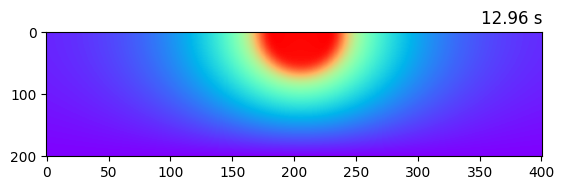

In [10]:
t=50;plt.imshow(X_T[t], aspect=0.5, cmap='rainbow'); plt.title(f'{time_T[t]:.2f} s', loc='right'); plt.show()

In [11]:
XT_reshaped = X_T[:, np.newaxis, :, :]  ## Adding Batch size of 1
XT_reshaped.shape

(97, 1, 201, 401)

In [12]:
XT_reshaped = torch.tensor(XT_reshaped, dtype=torch.float32)
dataset_T = TensorDataset(XT_reshaped)
dataloader_T = DataLoader(dataset_T, batch_size=1, shuffle=False)

In [13]:
model.eval()
with torch.no_grad():
    LIQ_pred_T = np.zeros_like(XT_reshaped)
    for i, inputs in enumerate(dataloader_T):
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        prediction = torch.sigmoid(outputs)
        prediction = (prediction > 0.5).float()
        prediction = prediction.cpu().numpy()
        LIQ_pred_T[i] = prediction[0]

LIQ_pred_T.shape

(97, 1, 201, 401)

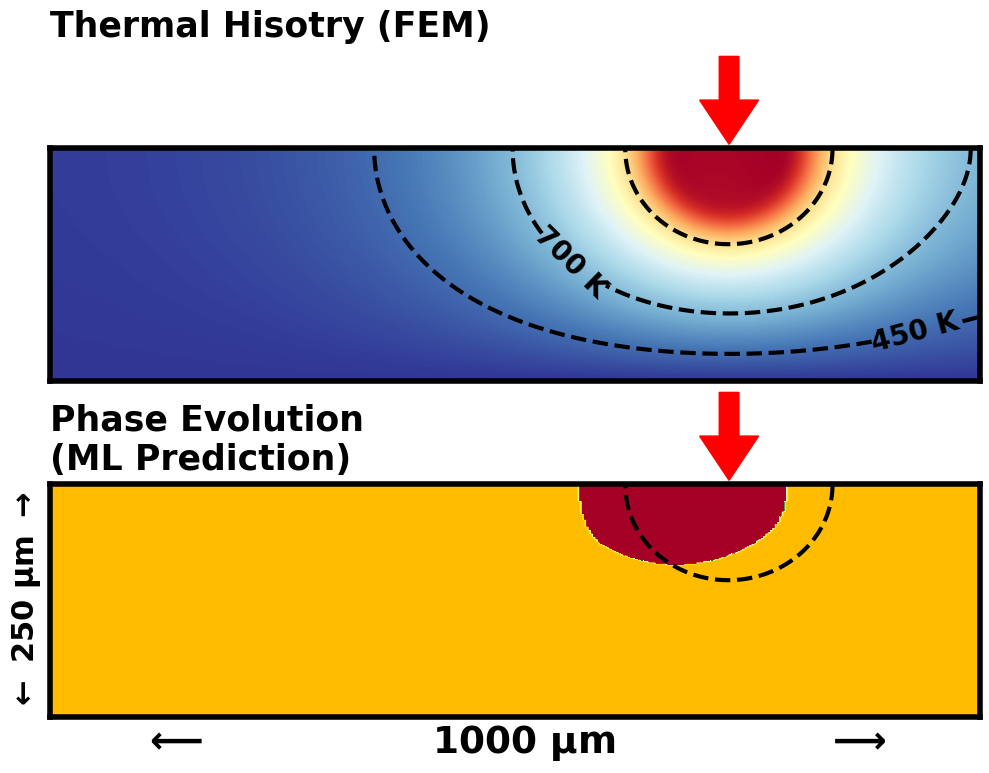

In [14]:
t_step = 80

laser_speed = 30
laser_pos = (125 + time_T[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension


fig2, (ax1, ax4) = plt.subplots(2, 1, figsize=(12, 8))

cmap = plt.get_cmap('RdYlBu_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(XT_reshaped[t_step][0], cmap='RdYlBu_r', vmin=300, aspect=0.5,  interpolation='quadric')
ax1.set_title('Thermal Hisotry (FEM)', pad=80, loc='left', fontsize=25, weight='bold')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax1.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_ylim(201, -1);  ax1.set_xlim(-1,401)
ax1.spines[:].set_linewidth(4)

contour_levels = [450, 700]
label_colors = ['k', 'k',]
contour = ax1.contour(XT_reshaped[t_step][0], levels=contour_levels, colors='black', linewidths=3, linestyles='dashed')
labels = plt.clabel(contour, inline=True, fontsize=20, fmt='%1.0f K')
for label, color in zip(labels, label_colors): label.set_fontweight('bold');label.set_color(color) 
ax1.spines[:].set_linewidth(4)
ax1.contour(XT_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')



cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap4a = ax4.imshow(LIQ_pred_T[t_step][0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5)
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap4b = ax4.imshow(1-LIQ_pred_T[t_step][0], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax4.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax4.set_ylim(201, -1);  ax4.set_xlim(-1,401)
ax4.set_title('Phase Evolution\n(ML Prediction)', pad=10, loc='left', fontsize=25, weight='bold')
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax4.set_xlabel('$\mathbf{\longleftarrow}$                 1000 $ \mathbf{\mu m}$                $\mathbf{\longrightarrow}$', fontsize = 27, weight ='bold',)
ax4.annotate(r'$\mathbf{\leftarrow}$ 250 $\mathbf{\mu m}$ $\mathbf{\rightarrow}$', xy=(0.5, 0.5), xytext=(-0.025, 0.5), rotation=90, xycoords='axes fraction', textcoords='axes fraction', fontsize = 22, weight = 'bold', color='k', ha='center', va='center')

ax4.spines[:].set_linewidth(4)
ax4.contour(XT_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')

plt.show()

In [49]:
# # Saving as Predicted Numpy Files
LIQ_pred_T = LIQ_pred_T[:,0,:,:]
np.save('../predictions/Ring_LIQ_pred_T.npy', LIQ_pred_T)

# Comparing Prediction with PF simulation

In [16]:
X_PF = np.load(path+'/1_Simulation_Results/ML_numpy_files/quant_data/pf_temp/Ring_X.npy')
y_PF = np.load(path+'/1_Simulation_Results/ML_numpy_files/quant_data/pf_temp/Ring_y.npy')
time_PF = np.load(path+'/1_Simulation_Results/ML_numpy_files/quant_data/pf_temp/Ring_time.npy')

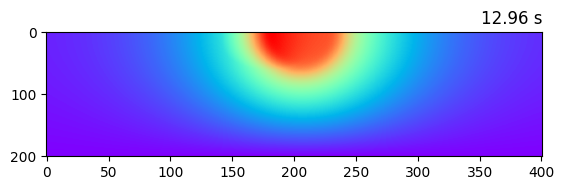

In [17]:
t=50;plt.imshow(X_PF[t], aspect=0.5, cmap='rainbow'); plt.title(f'{time_PF[t]:.2f} s', loc='right'); plt.show()

In [20]:
XPF_reshaped = X_PF[:, np.newaxis, :, :]
pred_error_PFT = LIQ_pred_T - y_PF[:, np.newaxis, :, :]

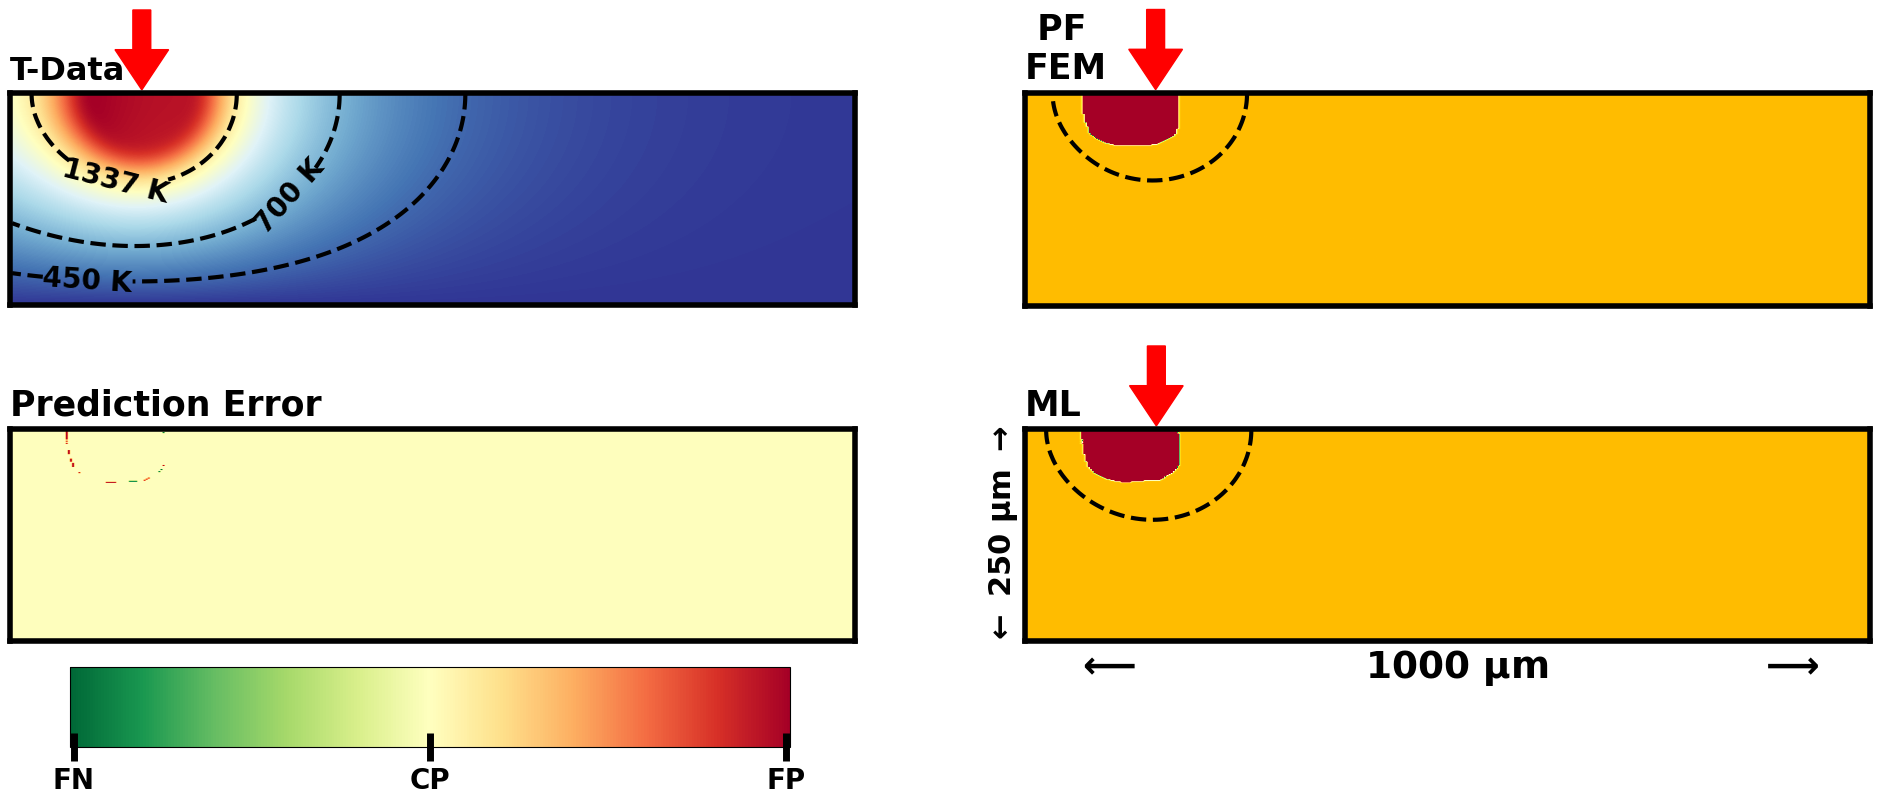

In [45]:
t_step = 0
laser_speed = 30
laser_pos = (125 + time_PF[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 8))

cmap = plt.get_cmap('RdYlBu_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(XT_reshaped[t_step][0], cmap='RdYlBu_r', vmin=300, aspect=0.5,  interpolation='quadric')
ax1.set_title('T-Data', pad=10, loc='left', fontsize=23, weight='bold')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax1.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_ylim(201, -1);  ax1.set_xlim(-1,401)
ax1.spines[:].set_linewidth(4)

contour_levels = [450, 700, 1337]
label_colors = ['k', 'k', 'k']
contour = ax1.contour(XT_reshaped[t_step][0], levels=contour_levels, colors='black', linewidths=3, linestyles='dashed')
labels = plt.clabel(contour, inline=True, fontsize=20, fmt='%1.0f K')
for label, color in zip(labels, label_colors): label.set_fontweight('bold');label.set_color(color) 
ax1.spines[:].set_linewidth(4)
# ax1.contour(XT_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')


cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap2 = ax2.imshow(y_PF[t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5)
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(1-y_PF[t_step], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax2.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax2.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax2.set_ylim(201, -1);  ax4.set_xlim(-1,401)
ax2.set_title(' PF\nFEM', pad=10, loc='left', fontsize=25, weight='bold')
ax2.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)

ax2.spines[:].set_linewidth(4)
ax2.contour(XPF_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')


cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap3 = ax3.imshow(pred_error_PFT[t_step][0], cmap=cmap, vmin=-1, vmax=1, aspect=0.5)
ax3.set_title('Prediction Error', pad=10, loc='left', fontsize=25, weight='bold')
ax3.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax5 = fig1.add_axes([0.15, 0.02, 0.3, 0.1])
cbar = fig1.colorbar(hmap3, cax=ax5, orientation='horizontal')
# ax5.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar.ax.tick_params(labelsize=20, direction='inout', length=20, width=5, rotation=0) 
cbar.set_ticks([-0.99,0,0.99], labels=['FN','CP','FP'], weight='bold')
ax3.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax3.set_ylim(201, -1);  ax3.set_xlim(-1,401)
ax3.spines[:].set_linewidth(4)


cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap4a = ax4.imshow(LIQ_pred_T[t_step][0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5)
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap4b = ax4.imshow(1-LIQ_pred_T[t_step][0], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax4.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax4.set_ylim(201, -1);  ax4.set_xlim(-1,401)
ax4.set_title('ML', pad=10, loc='left', fontsize=25, weight='bold')
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax4.set_xlabel('$\mathbf{\longleftarrow}$                 1000 $ \mathbf{\mu m}$                $\mathbf{\longrightarrow}$', fontsize = 27, weight ='bold',)
ax4.annotate(r'$\mathbf{\leftarrow}$ 250 $\mathbf{\mu m}$ $\mathbf{\rightarrow}$', xy=(0.5, 0.5), xytext=(-0.025, 0.5), rotation=90, xycoords='axes fraction', textcoords='axes fraction', fontsize = 22, weight = 'bold', color='k', ha='center', va='center')

ax4.spines[:].set_linewidth(4)
ax4.contour(XT_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')

plt.show()